In [1]:
import os
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np

import utils

In [2]:
%matplotlib inline

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
main_path = Path.cwd() / ".."

---

##### Cargamos las imágenes a usar en los ejercicios

In [4]:
folder_path = main_path / "data/images"

dict_imgs = {}
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)

    name, _ = os.path.splitext(filename)
    dict_imgs[name] = cv2.imread(file_path)

dict_imgs_gray = {}
for name, img in dict_imgs.items():
    dict_imgs_gray[name] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

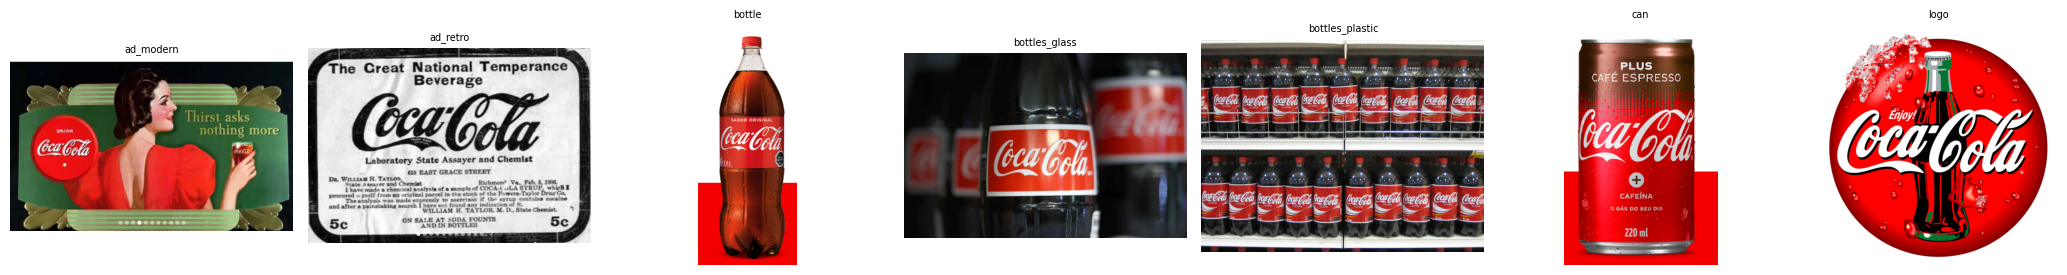

In [5]:
utils.plot_imgs(list(dict_imgs.values()), list(dict_imgs.keys()), rows=1, figsize=3)

In [6]:
print("Images shape:\n")
for name, img in dict_imgs.items():
    blank = " "
    print(f"{name}:{blank*(16-len(name))} h_{img.shape[0]}, w_{img.shape[1]}")

Images shape:

ad_modern:        h_429, w_715
ad_retro:         h_493, w_715
bottle:           h_500, w_207
bottles_glass:    h_450, w_687
bottles_plastic:  h_598, w_799
can:              h_363, w_233
logo:             h_1389, w_1389


In [7]:
folder_path = main_path / "data/template"
filename = "logo_template.png"
file_path = os.path.join(folder_path, filename)

template = cv2.imread(file_path)
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

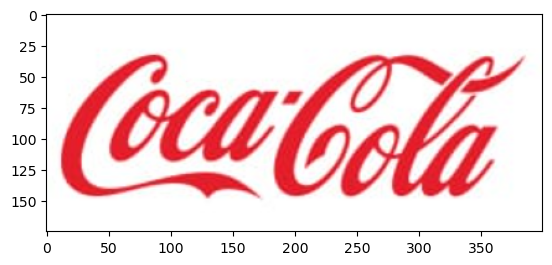

In [8]:
plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))

---
##### Ejercicio 1.

Obtener una detección del logo en cada imagen sin falsos positivos.

Como podemos observar, los logos en las imagenes sobre las que vamos a buscar están en blanco sobre rojo o negro sobre blanco. Por lo cual un template con el logo en tono medio (rojo) sobre fondo blanco va a ser subóptimo para matchear.

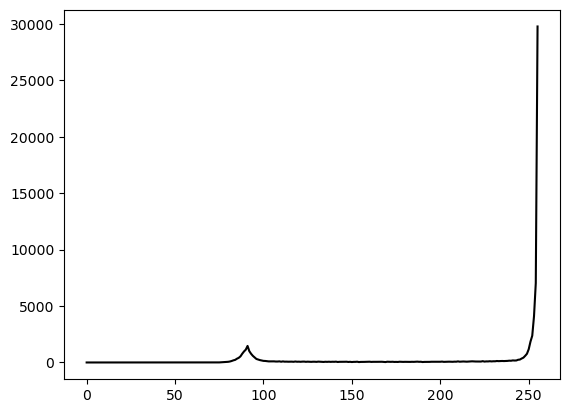

In [9]:
histogram = cv2.calcHist([template_gray], [0], None, [256], [0, 256])
plt.plot(histogram, color='black')

plt.show()

Se observa que el color rojo del template corresponde a un valor de gris de intesidad 90. Con lo cual vamos a armar un template cuyo fondo sea valor 90 (rojo de las etiquetas en las imágenes) y cuyo texto sea valor 255. Además vamos a generar el template inverso para matchear los casos en los que el texto es negro sobre gris claro (ej: ad_retro).

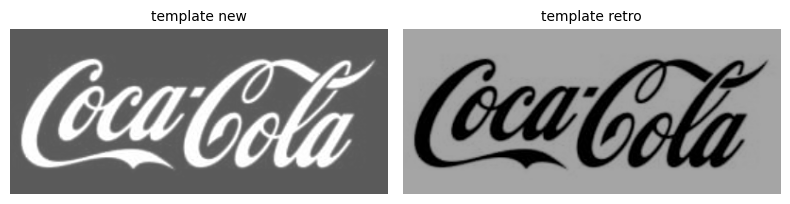

In [10]:
template_new = 255 - template_gray
template_new = np.clip(template_new.astype(np.uint16) + 90, 0, 255).astype(np.uint8)
template_retro = 255 - template_new

utils.plot_imgs([template_new, template_retro], ["template new", "template retro"], rows=1, figsize=4)

Encontramos además logos de diversos tamaños en las imágenes sobre las que vamos a matchear. Por este motivo vamos a tener que generar templates de diversas escalas para poder matchearlos.

logo menor: h_15, w_40


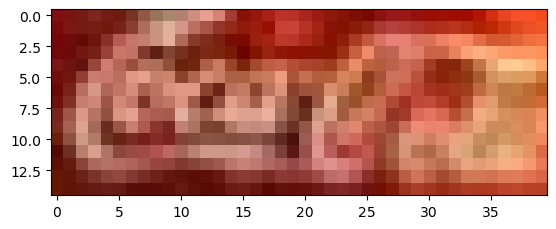

In [11]:
# Logo de menor encontrado en las imágenes
logo_menor = dict_imgs["ad_modern"][220:235,565:605,:]
print(f"logo menor: h_{logo_menor.shape[0]}, w_{logo_menor.shape[1]}")

plt.imshow(cv2.cvtColor(logo_menor, cv2.COLOR_BGR2RGB))

logo mayor: h_400, w_1155


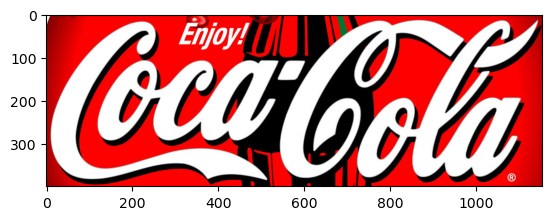

In [12]:
# Logo de mayor tamaño encontrado en las imágenes
logo_mayor = dict_imgs["logo"][470:870,95:1250,:]
print(f"logo mayor: h_{logo_mayor.shape[0]}, w_{logo_mayor.shape[1]}")

plt.imshow(cv2.cvtColor(logo_mayor, cv2.COLOR_BGR2RGB))

In [14]:
scales = np.linspace(0.1, 3, 21)

list_templates_gray = []
for scale in scales:
    list_templates_gray.append(cv2.resize(template_new, None, fx=scale, fy=scale))
    list_templates_gray.append(cv2.resize(template_retro, None, fx=scale, fy=scale))

In [28]:
meth = 'cv2.TM_SQDIFF'
method = eval(meth)

list_shape = []
list_loc = []
list_val = []
for template in list_templates_gray:
    try:
        res = cv2.matchTemplate(dict_imgs_gray["ad_retro"], template, method)
    except Exception as e:
        break

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc

    list_shape.append(template.shape[:2])
    list_loc.append(top_left)
    list_val.append(min_val)

    

In [27]:
list_val

[4126862.0,
 4043629.0,
 34213296.0,
 35043536.0,
 88478624.0,
 91863632.0,
 186230944.0,
 187237504.0,
 291133376.0,
 317920640.0,
 420225920.0,
 489811712.0,
 652017280.0,
 711585152.0,
 922024704.0,
 831199488.0,
 1218143872.0,
 855079040.0,
 1540264960.0,
 1159734784.0,
 1886765312.0,
 1853998080.0,
 2263639040.0,
 2406786560.0]

In [48]:
list_annotated = []
for i, loc in enumerate(list_loc):
    img_salida = dict_imgs_gray["ad_retro"].copy()

    bottom_right = (loc[1] + list_shape[i][1], loc[0] + list_shape[i][0])
    cv2.rectangle(img_salida, loc, bottom_right, color=(0, 0, 0), thickness=5)

    list_annotated.append(img_salida)

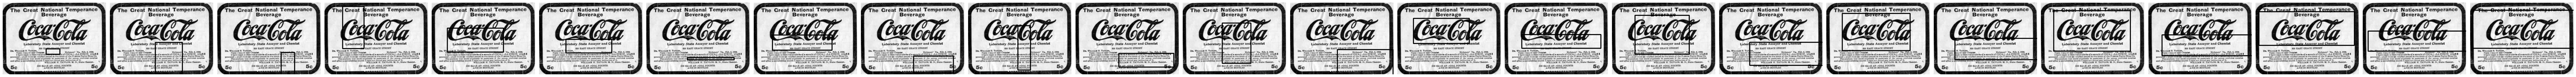

In [49]:
utils.plot_imgs(list_annotated, rows=1,  figsize=4)

In [51]:
loc

(17, 53)